In [ ]:
# default_exp funcs.routines

In [ ]:
%load_ext autoreload
%autoreload 2

# Visualization tools 

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
from decode_fish.funcs.visualization import *
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.dataset import EstimateBackground
import h5py

base_path =  '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/'

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
#export
def get_df_from_hdf5(group):
    
    df = DF()
    for k in group.keys():
        df[k] = group[k][()]
    return df

def add_df_to_hdf5(parent, name, df):
    
    g = parent.create_group(name)
    for k in df.keys():
        g.create_dataset(k, data=df[k].values)

In [ ]:
#export
def sim_data(decode_dl, batches, micro):
    
    gt_dfs = []
    xsim_col = []
    
    for _ in range(batches):
        with torch.no_grad():
            x, local_rate, background = next(iter(decode_dl))
            sim_vars = PointProcessUniform(local_rate,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc).sample()
            xsim = micro(*sim_vars)
            x = micro.noise(xsim, background).sample()

            xsim_col.append(x)
            gt_vars = sim_vars[:-1]
            gt_dfs.append(sample_to_df(*gt_vars, px_size_zyx=[1.,1.,1.]))
        
    return torch.cat(xsim_col), cat_emitter_dfs(gt_dfs, decode_dl.batch_size)

def get_sim_perf(x, gt_df, model, post_proc, micro, cuda=True, print_res=True):

    pred_dfs = []
    x_recs = []
    
    for i in range(len(x)):
        with torch.no_grad():
            pred_df, rec, res_dict = get_prediction(model, post_proc, x[i:i+1], micro=micro, cuda=True, return_rec=True, min_int=-100)
            pred_dfs.append(pred_df)
            x_recs.append(rec)
        
    pred_df = cat_emitter_dfs(pred_dfs)
    xrec = torch.cat(x_recs)
    perf, matches, _ = matching(gt_df, pred_df, tolerance=500, print_res=print_res)
    perf['mae'] = abs(xrec-rec).mean().item()
    perf['rmse'] = torch.sqrt(((xrec-rec)**2).mean()).item()
    
    return perf, pred_df, matches

def get_reconstruction_from_df(df, micro, output_shape, px_size_zyx=[100,100,100]):
    
    output_shape = torch.Size([1]*(5-len(output_shape))+list(output_shape))
    locs, x, y, z, ints = df_to_micro(df, px_size_zyx)
    rec_img = micro(locs, x, y, z, ints, output_shape)   
    return rec_img


In [ ]:
# xsim, gt = sim_data(decode_dl, 10, micro)
# perf, pred_df, matches = get_sim_perf(xsim, px_to_nm(gt, cfg.evaluation.px_size_zyx), model, post_proc, micro, print_res=True)

# plt.scatter(matches['int_tar'], matches['int_pred'])
# plt.plot([0,10],[0,10])

In [ ]:
def filt_perc(df, perc = 90, return_low=True, metric='comb_sig'):
    if perc >= 100:
        return df
    ret_df = DF()
    for f in dec_df_col['frame_idx'].unique():
        frame_df = df[df['frame_idx']==f]
        filt_val = np.percentile(frame_df[metric], perc)
        print(filt_val)
        if return_low:
            frame_df = frame_df[frame_df[metric] < filt_val]
        else:
            frame_df = frame_df[frame_df[metric] > filt_val]
        ret_df = ret_df.append(frame_df)
    return ret_df


def int_hist_nnnew(df, micro):
    ints = df['int']#*micro.int_sig.item() + micro.int_mu.item() - micro.int_mu.item() * micro.min_fac
    dist_samp = cpu(torch.distributions.Gamma(model.int_dist.int_conc.item(), model.int_dist.int_rate.item()).sample([10000]))+model.int_dist.int_loc.item()

    max_bin = dist_samp.max()
    print(ints.min())
    _ = plt.hist(ints, bins=np.linspace(0,max_bin,101), density=True, label='Predictions')
    _ = plt.hist(dist_samp, density=True, bins=np.linspace(0,max_bin,101), alpha=0.5, label='Distr.')
    plt.plot([model.int_dist.int_loc.item(),model.int_dist.int_loc.item()],[0,1], color='red')
    plt.title(ints.mean())
    plt.legend()
    
def psf_rmse(psf1, psf2):
    return np.sqrt(np.mean((psf1-psf2)**2))

def psf_corr(psf1, psf2):
    return np.corrcoef(psf1.reshape(-1), psf2.reshape(-1))[0,1]

2.2142758


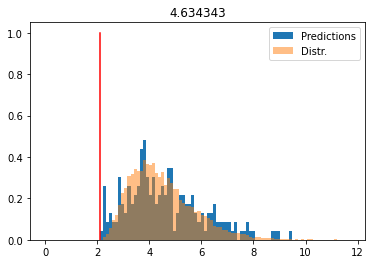

In [ ]:
int_hist_nnnew(dec_df, micro)

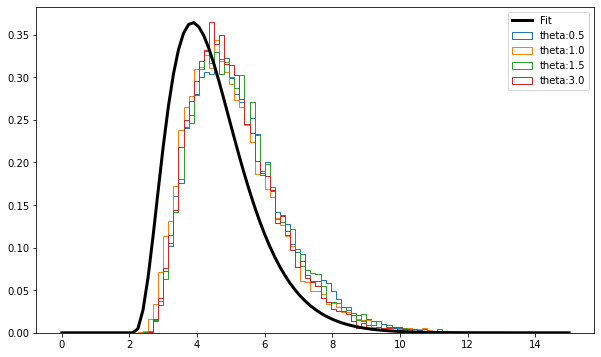

In [ ]:
import scipy.stats as stats  

plt.figure(figsize=(10,6))

#Fit parameters: 
shape = 3.7504156297802815, 
scale = 0.6406917808418713, 
locaction = 2.104038290757017

# files = sorted(glob.glob('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_ff18/*/train.yaml'))
files = sorted(glob.glob('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fj3/*/train.yaml'))
cfg = OmegaConf.load(files[0])
model = hydra.utils.instantiate(cfg.model)

for f in files[:]:
#     cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fd1/int_mu:{m}//train.yaml')
    cfg = OmegaConf.load(f)
    name = str(Path(f).parent).split('/')[-1]

    cfg.microscope._target_ = 'decode_fish.engine.microscope.Microscope'      
    path = Path(cfg.output.save_dir)
    model = load_model_state(model, path, 'model.pkl')
    
    _ = plt.hist(cpu(torch.distributions.Gamma(model.int_dist.int_conc.item(), model.int_dist.int_rate.item()).sample([10000]))+model.int_dist.int_loc.item(), 
                 bins=np.linspace(0,15,101),histtype='step', label=name, density=True)

x = np.linspace(0,15,101)
y = stats.gamma.pdf(x, shape, locaction, scale)
plt.plot(x, y, label='Fit', linewidth=3, color='black')
    
plt.legend()

In [ ]:
# img_6D     = reshape(img_large,[factor_binning size_img(1) factor_binning size_img(2) factor_binning size_img(3)]);
# img_fish   = round(reshape(sum(sum(sum(img_6D,1),3),5),size_img)./(factor_binning^3));

In [ ]:
large_psf = cpu(load_tiff_image('../figures/PSF.tif')[0])
small_psf = large_psf[:-1,:-1,:-1].reshape([10,3,20,3,20,3]).sum(1).sum(2).sum(3)/27

In [ ]:
gt_psf = cpu(load_tiff_image(cfg.evaluation.psf_path)[0])
gt_psf /= gt_psf.max()

In [ ]:
!ls /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fi2c

norm_reg:0.01  norm_reg:0.05  norm_reg:0.2  norm_reg:0.5  norm_reg:1.0


In [ ]:
from decode_fish.engine.psf import LinearInterpolatedPSF
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_f4/min_fac:0.4/train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_f5/int_mu:4.0//train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fb6/int_mu:2.0/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fj3/theta:1.0/train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fi3d/seed:3/train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fi7_gt/seed:4/train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fh9/seed:4/train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fi2c/norm_reg:0.01/train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/psf_opt_runs/i_psf_max_norm_foci_3loc/train.yaml')
# cfg.microscope._target_ = 'decode_fish.engine.microscope.Microscope'

cfg.foci.n_foci_avg = 0.0
model, post_proc, psf, micro, img_3d, decode_dl = load_all(cfg, False)

psf_init = get_gaussian_psf(cfg.PSF.psf_extent_zyx,cfg.PSF.gauss_radii)
psf_init = cpu(psf_init.psf_volume[0])
psf_vol = cpu(psf.psf_volume[0])
psf_init /= psf_init.max()
psf_vol /= psf_vol.max()

20 volumes


(tensor(5.0000, device='cuda:0', grad_fn=<DivBackward0>), tensor(9.9992, device='cuda:0', grad_fn=<DivBackward0>), tensor(10.0002, device='cuda:0', grad_fn=<DivBackward0>))
Sum:  100.150894 102.56072 15.749611
CSum:  100.150894 102.601364 15.749611
Max:  1.0 1.0 1.0
RMSE init:  0.029397821
RMSE:  0.0063308226
Corr init:  0.9240543227119584
Corr:  0.9936315466608754


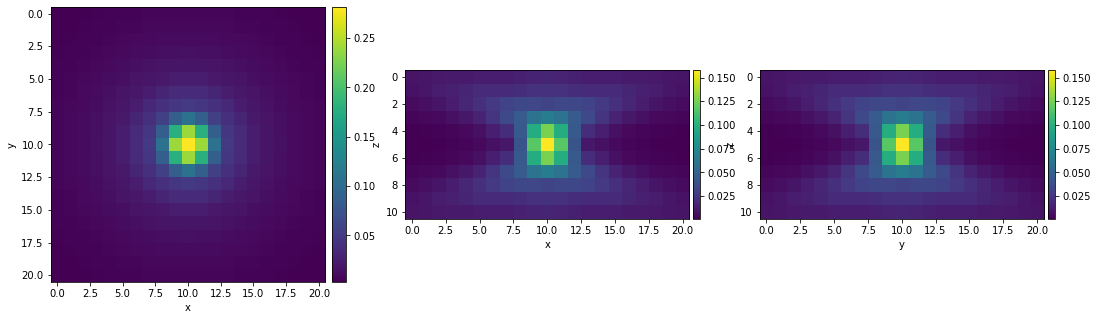

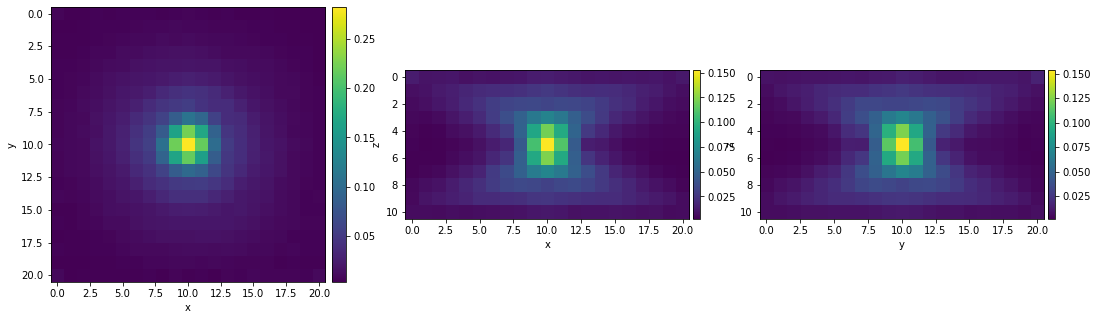

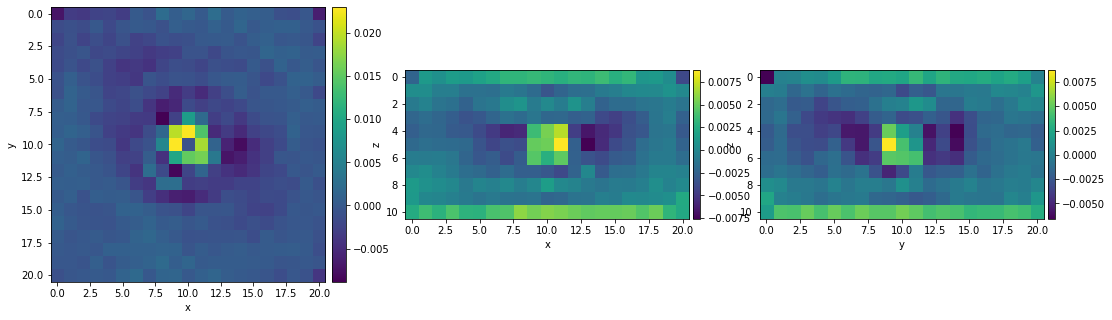

In [ ]:
print(psf.get_com())
plot_3d_projections(gt_psf)
plot_3d_projections(psf_vol)
plot_3d_projections(gt_psf-psf_vol[:,::-1,::-1])
print('Sum: ', gt_psf.sum(), psf_vol.sum(), psf_init.sum())
print('CSum: ', gt_psf.sum(), np.clip(psf_vol,0,10).sum(), psf_init.sum())
print('Max: ', gt_psf.max(), psf_vol.max(), psf_init.max())
print('RMSE init: ', psf_rmse(gt_psf, psf_init))
print('RMSE: ', psf_rmse(gt_psf, psf_vol))
print('Corr init: ', psf_corr(gt_psf, psf_init))
print('Corr: ', psf_corr(gt_psf, psf_vol))

In [ ]:
# plot_3d_projections(psf.psf_volume[0]-psf_init.psf_volume[0])

100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Recall: 0.994
Precision: 0.946
Jaccard: 94.054
RMSE_vol: 31.891
Eff_3d: 82.982
FN: 1.0 FP: 10.0
Shift: -0.63,0.80,0.77
1.0514285714285714


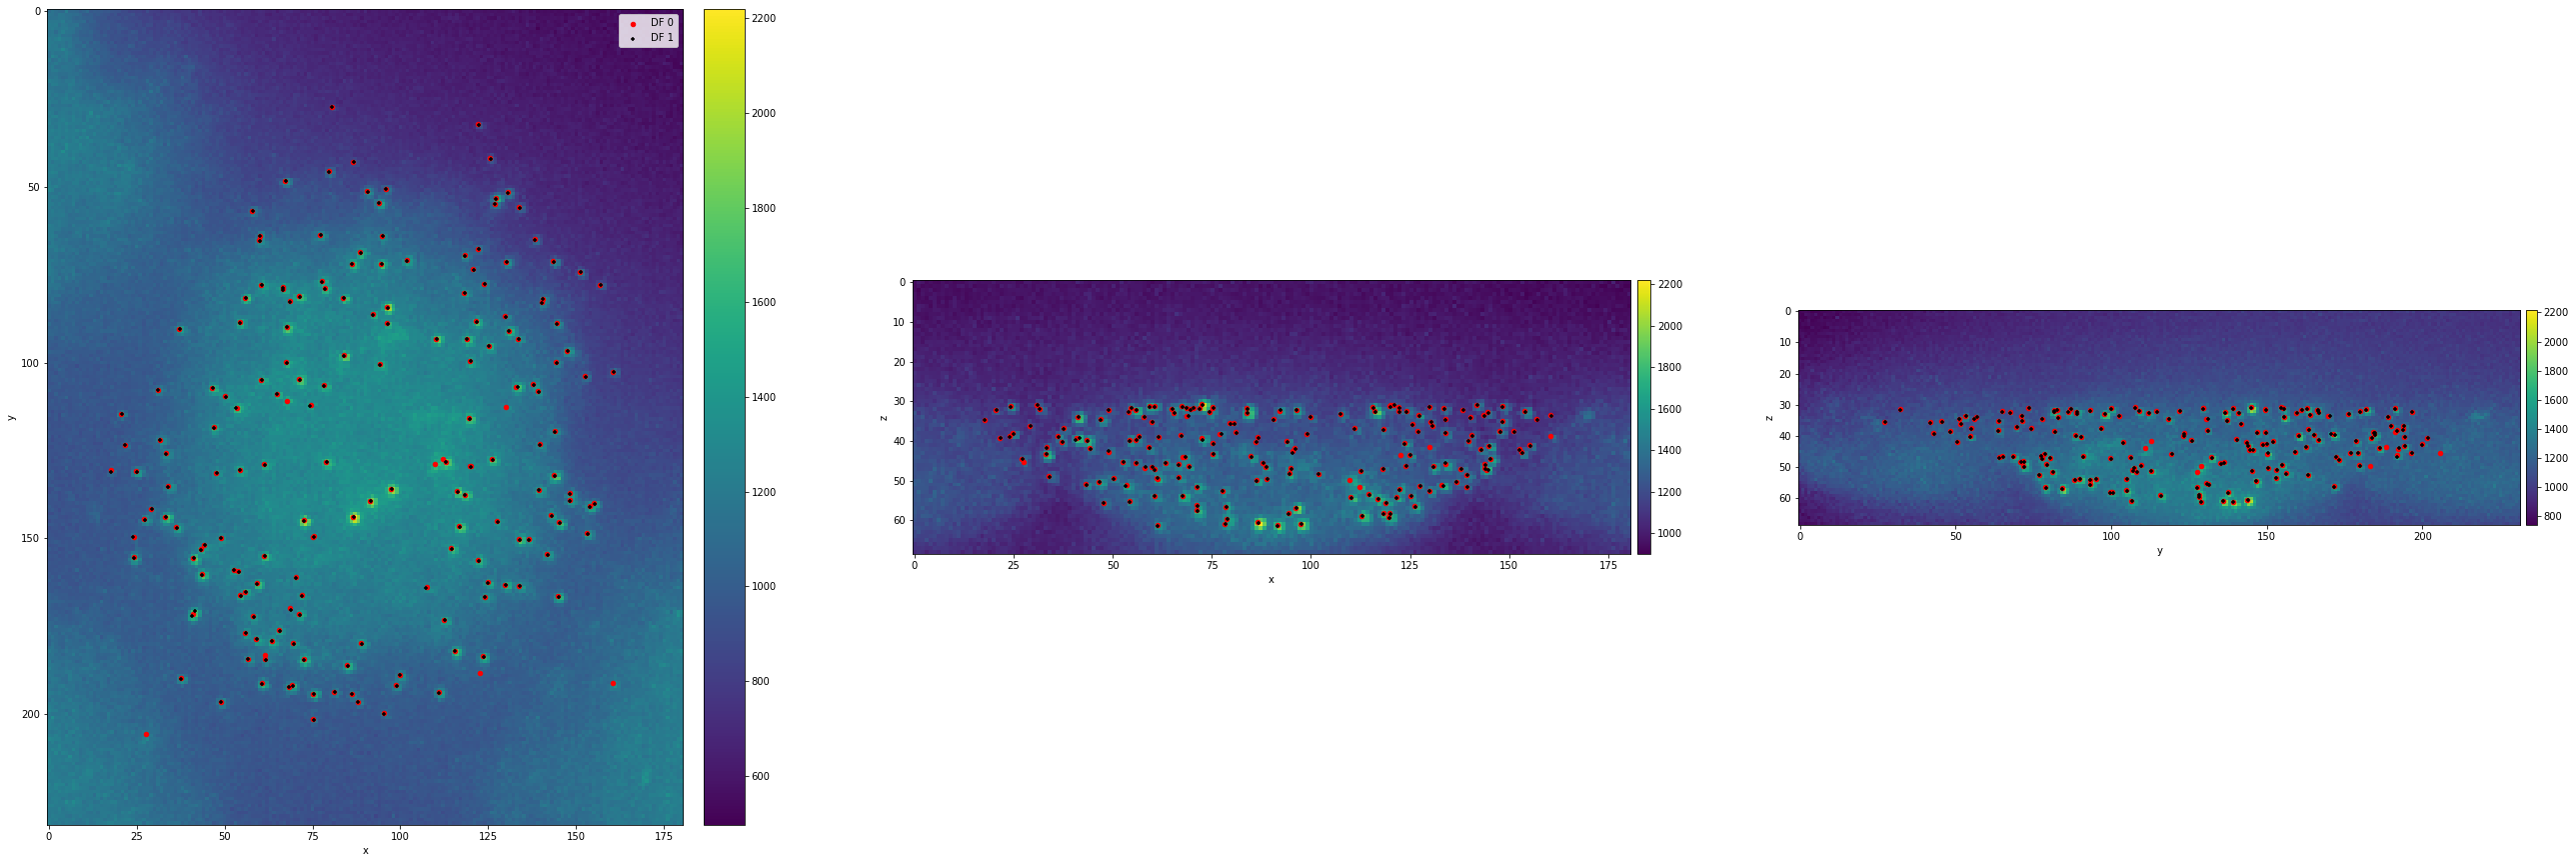

In [ ]:
model.cuda()
ind = 0
sl = np.s_[:,:,:,:]
# sl = np.s_[:,30:,150:180,115:135]
# basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_foci_fac1_1//'
# img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 100, 'foci', 'strong', ind)

basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_2/'
gt_df_col = DF()
fq_df_col = DF()
dec_df_col = DF()
for ind in tqdm([0]):
    img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 250, 'random', 'NR', ind)
    bg_est = EstimateBackground(smoothing_filter_size=cfg.bg_estimation.smoothing_filter_size)(img)
    bg_gt = load_tiff_image('/groups/turaga/home/speisera/share_TUM/FishSIM/bg_tifs/w1_HelaKyoto_Gapdh_2597_p01_cy3__Cell_CP_10.tif')
    img_in = img #- bg_gt + bg_est # bg_gt.mean()
#     gt_df = crop_df(gt_df, sl, px_size_zyx=[300,100,100])
    fq_gmm_df = crop_df(fq_gmm_df, sl, px_size_zyx=[300,100,100])
    with torch.no_grad():
        dec_df = shift_df(post_proc(model(img_in[sl][None].cuda()), 'df'), [-100,-100,-300])
        free_mem()
    gt_df_col = cat_emitter_dfs([gt_df_col, gt_df])
    fq_df_col = cat_emitter_dfs([fq_df_col, fq_gmm_df])
    dec_df_col = cat_emitter_dfs([dec_df_col, dec_df])
    
# dec_df_col = sig_filt(dec_df_col, 80)
perf_df, matches, shift = matching(gt_df_col, dec_df_col, print_res=False)
dec_df_col = shift_df(dec_df_col, shift)

axes = plot_3d_projections(img_in[sl][0], 'max', size=15)
scat_3d_projections(axes, [dec_df, gt_df], px_size_zyx=[300,100,100])
perf_df, matches, _ = matching(gt_df_col, dec_df_col, print_res=True)

print(len(dec_df_col)/len(gt_df_col))

In [ ]:
dec_df_filt = sig_filt(dec_df_col, 95)
perf_df, matches, shift = matching(gt_df_col, dec_df_filt, print_res=True)

Recall: 0.971
Precision: 0.988
Jaccard: 96.045
RMSE_vol: 29.013
Eff_3d: 84.964
FN: 5.0 FP: 2.0
Shift: -0.08,-0.06,0.20


1.13


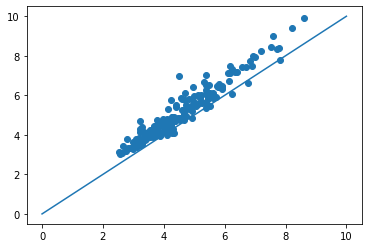

In [ ]:
plt.scatter(matches['int_tar'], matches['int_pred'])
print(np.round(np.linalg.lstsq(matches['int_tar'].values.reshape(-1,1), matches['int_pred'].values, rcond=None)[0][0],2))
plt.plot([0,10],[0,10])

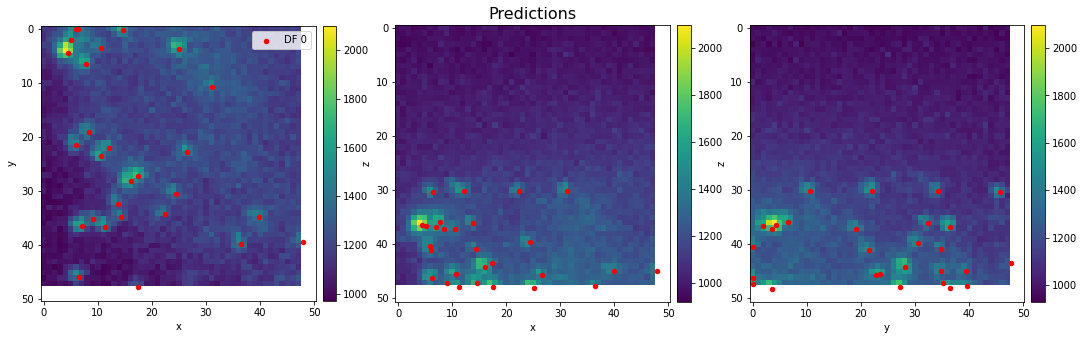

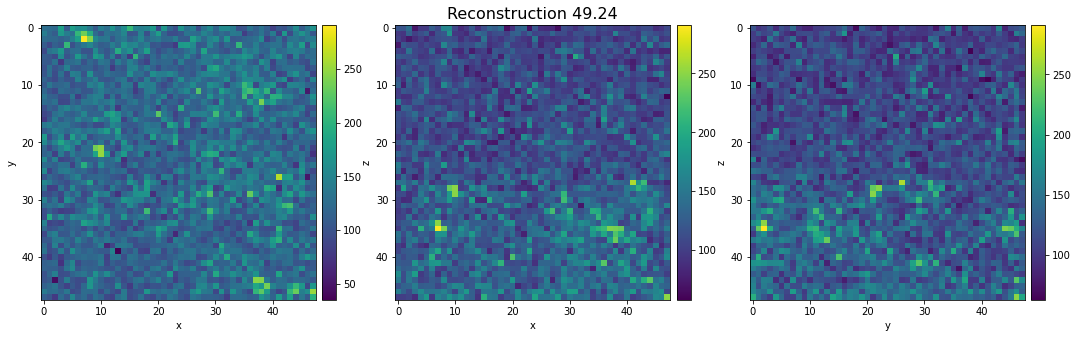

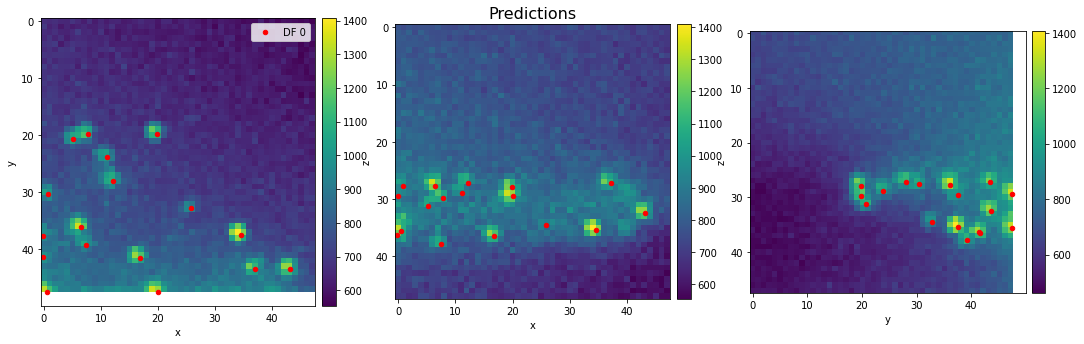

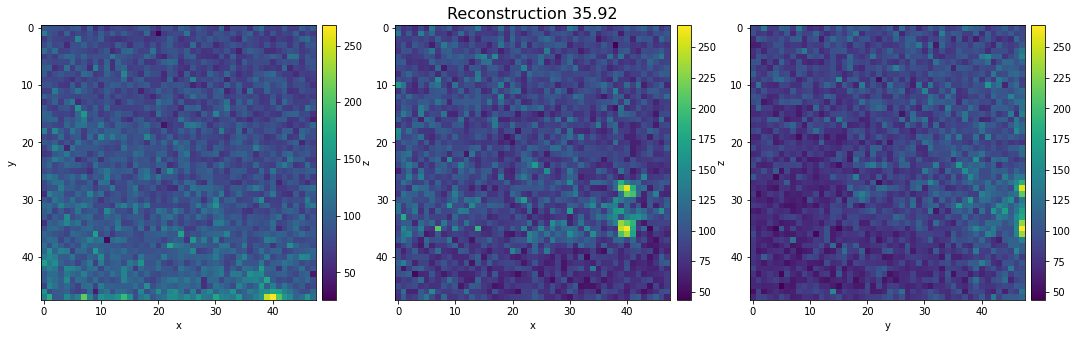

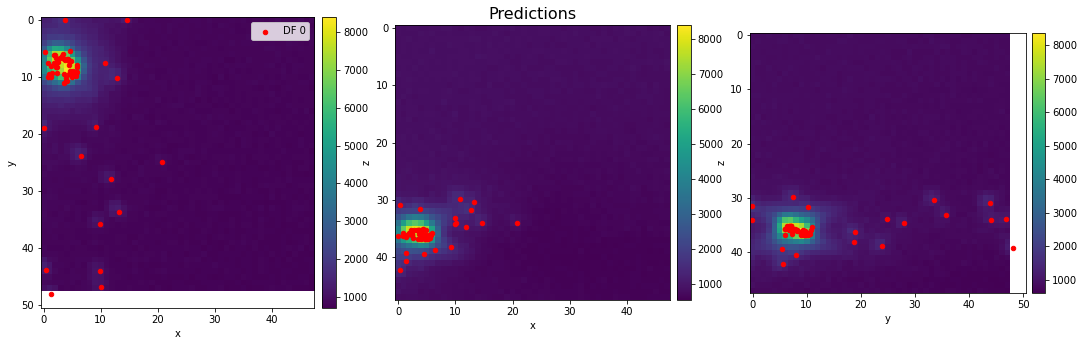

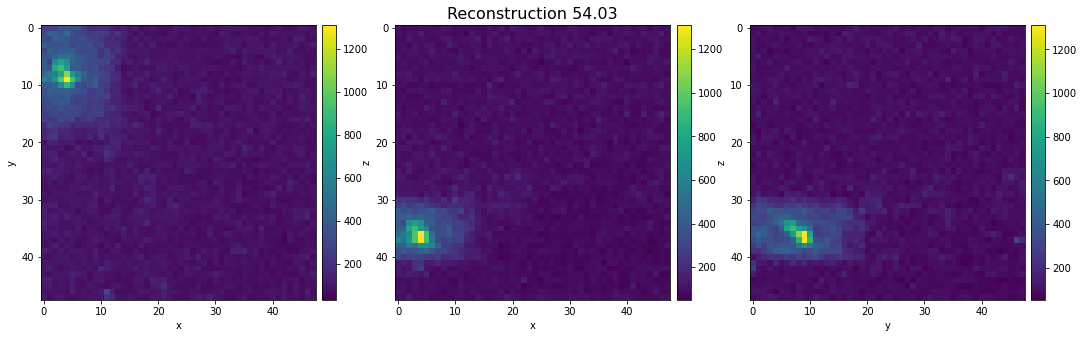

In [ ]:
eval_random_crop(decode_dl, model, post_proc, micro, projection='max', samples=3, int_threshold=1000)

In [ ]:
basedir

'/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_2/'

In [ ]:
from decode_fish.funcs.fit_psf import get_peaks_3d
from decode_fish.funcs.fit_psf import plot_detection
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_foci_fac1_1/'

files = sorted(glob.glob('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fj1/*/train.yaml'))

dec_count_col = []
prob_sum_col = []
names = []

for f in files:
        
    cfg = OmegaConf.load(f)
    names.append(str(Path(f).parent).split('/')[-1])
#     model, post_proc, psf, micro, img_3d, decode_dl = load_all(cfg, False)
    model = load_model_state(model, Path(cfg.output.save_dir), 'model.pkl')
    _ = model.cuda()

    box_sz = 10
    n_cells = 20
    gt_counts = []
    fq_counts = []
    dec_counts = []
    prob_sums = []

    for i in tqdm(range(n_cells)):

        img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 100, 'foci', 'strong', i)
        gt_px = nm_to_px(gt_df, px_size_zyx=[300,100,100])
        fq_px = nm_to_px(fq_gmm_df, px_size_zyx=[300,100,100])
        with torch.no_grad():
            res_dict = model(img[None].cuda())
            dec_df = shift_df(post_proc(res_dict, 'df'), [-100,-100,-100])
            free_mem()
        dec_px = nm_to_px(dec_df, px_size_zyx=[300,100,100])

        try:
            coords_xyz = get_peaks_3d(img[0], threshold=2000, min_distance=10)
        except AssertionError:
            continue
        coords_zyx = coords_xyz[:,::-1]

        for c in coords_zyx:
            sl = np.s_[:,c[0]-box_sz:c[0]+box_sz+1, c[1]-box_sz:c[1]+box_sz+1, c[2]-box_sz:c[2]+box_sz+1]
            gt_crop = crop_df(gt_px, sl)
            fq_crop = crop_df(fq_px, sl)
            dec_crop = crop_df(dec_px, sl)
            prob_crop = torch.sigmoid(res_dict['logits'])[0][sl]

            gt_counts.append(len(gt_crop))
            fq_counts.append(len(fq_crop))
            dec_counts.append(len(dec_crop))
            prob_sums.append(prob_crop.sum().item())
            
    dec_count_col.append(dec_counts)
    prob_sum_col.append(prob_sums)

 55%|█████▌    | 11/20 [00:09<00:07,  1.14it/s]


RuntimeError: CUDA out of memory. Tried to allocate 2.71 GiB (GPU 0; 11.78 GiB total capacity; 6.35 GiB already allocated; 1.29 GiB free; 7.04 GiB reserved in total by PyTorch)

In [ ]:
plt.figure(figsize=(15,8))
import seaborn as sns
plt.subplot(121)
corr = np.round(np.corrcoef([gt_counts, fq_counts])[0,1],3)
plt.scatter(gt_counts, fq_counts, label=f'FISH-quant. Corr: {corr}')
for i,c in enumerate(prob_sum_col):
    corr = np.round(np.corrcoef([gt_counts, c])[0,1],3)
    plt.scatter(gt_counts, c, label=f'DEC {names[i]} probs. Corr: {corr}', alpha=1.0)
    
plt.plot([0,100],[0,100], 'red')
plt.xlabel('Ground truth N mRNA')
plt.ylabel('Predicted N mRNA')
plt.xlim(0,40)
plt.ylim(0,40)
plt.legend()
sns.despine()

plt.subplot(122)
corr = np.round(np.corrcoef([gt_counts, fq_counts])[0,1],3)
plt.scatter(gt_counts, fq_counts, label=f'FISH-quant. Corr: {corr}')

for i,c in enumerate(dec_count_col[2:3]):
    corr = np.round(np.corrcoef([gt_counts, c])[0,1],3)
    plt.scatter(gt_counts, c, label=f'DEC {names[i]} counts. Corr: {corr}', alpha=1.0)

plt.plot([0,100],[0,100], 'red')
plt.xlabel('Ground truth N mRNA')
plt.ylabel('Predicted N mRNA')
plt.xlim(0,40)
plt.ylim(0,40)

plt.legend()
sns.despine()
# print('Corr. DECODE: ', np.corrcoef([gt_counts, dec_counts])[0,1])

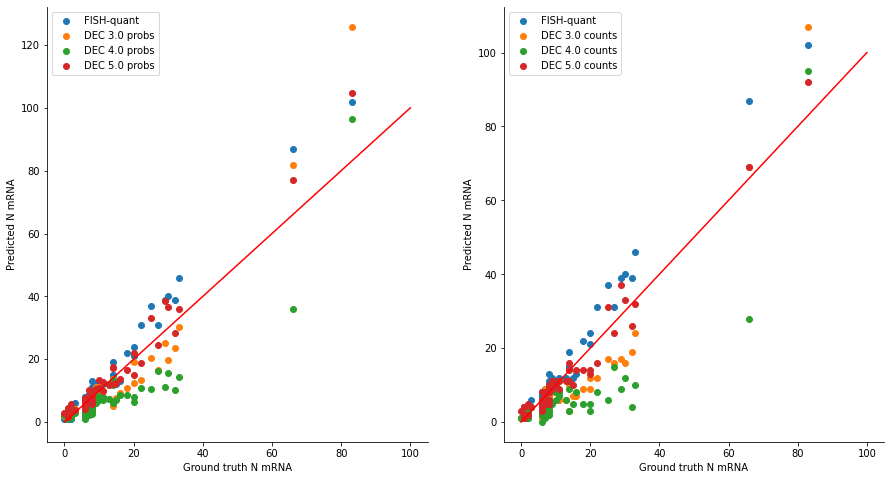

In [ ]:
plt.figure(figsize=(15,8))
import seaborn as sns
plt.subplot(121)
plt.scatter(gt_counts, fq_counts, label='FISH-quant')
for i,c in enumerate(prob_sum_col):
    plt.scatter(gt_counts, c, label=f'DEC {mults[i]} probs')
    
plt.plot([0,100],[0,100], 'red')
plt.xlabel('Ground truth N mRNA')
plt.ylabel('Predicted N mRNA')
plt.legend()
sns.despine()

plt.subplot(122)
plt.scatter(gt_counts, fq_counts, label='FISH-quant')

for i,c in enumerate(dec_count_col):
    plt.scatter(gt_counts, c, label=f'DEC {mults[i]} counts')

plt.plot([0,100],[0,100], 'red')
plt.xlabel('Ground truth N mRNA')
plt.ylabel('Predicted N mRNA')
plt.legend()
sns.despine()
# print('Corr. FQ: ', np.corrcoef([gt_counts, fq_counts])[0,1])
# print('Corr. DECODE: ', np.corrcoef([gt_counts, dec_counts])[0,1])


In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted index.ipynb.
